# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera 
##### Alessandro Bonvini, February 11th 2021

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data loading and preprocessing](#data)
* [Cluster neighborhoods](#cluster)
* [Usage of Foursquare API](#foursquare)
* [Regression: training models](#training)
* [Regression: testing the best models](#testing)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The goal of this project is to study the impact of using Foursquare API on the regression problem of predicting house prices in the Italian city of Monza.

The house prices prediction can be a useful feature to be implemented in houses selling announcements search engines.  
With this feature implemented, in fact, the seller can have an idea of the reasonable value of the house that he wants to sell and he can be warned if the price of the announcement is too far from the fair price. At the same time, the buyer can understand what a good price for the house that he wants to buy could be, obtaining an indication about the price fairness.

The possible advantage of using Foursquare API is related to the fact that the square meter price of the houses in Monza, like in most of cities, varies depending on the position of the house. The presence of one or more important monument, church or square or famous restaurants, shopping centers etc. close to a house, in fact, will likely have an impact to its square meter price.
We will check if the information given by Foursquare API could be used to retrieve spatial information that can be used by the regression models.

In particular we will use Foursquare information to automatically cluster the houses in trending neighborhoods and then use the obtained cluster information as an additional feature used by the machine learning models. 
Alternatively, we will explore if adding the top trending venues directly as features to the models will lead to a better performance with respect to using the cluster information or no spatial information at all.

We will test 4 regression models: Multivariate Linear Regression, Ridge Regression with 3rd degree Polynomial Features, SVR and Random Forest.

## Data loading and preprocessing <a name="data"></a>

After searching for available data sources that could be used for the project, I realized that no houses databases are public available. 

Therefore, with the help of an estate agent working in Monza, we selected what could be the most impacting features to the house prices and we extracted hundreds of houses from his management system database, compiling afterwards some chosen features for each house. 

In [56]:
# Let's first import the libraries that will be used in the project
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
import matplotlib.pyplot as plt
from matplotlib import cm
import branca.colormap as cm
import seaborn
#!conda install -c conda-forge geopy --yes
import geopy.geocoders as gc
import requests
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
pd.set_option('max_columns', None)

The training houses dataset is in csv format, so it is possible to open it with pandas.
Let's open it and see how it looks like.

In [57]:
# Read initial csv file
houses_df = pd.read_csv("HOUSES.csv", delimiter=";")
houses_df.head(10)

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE
0,5317000,6 viale Cesare Battisti,5,542,3,GROUND,2,1900,RENOVATED,NO,YES,NO,A,1,EXPENSIVE
1,2970000,6 viale Cesare Battisti,4,295,3,MIDDLE,2,1900,RENOVATED,YES,NO,NO,A,1,EXPENSIVE
2,280000,3 via Ambrosini,3,115,2,MIDDLE,1,1980,GOOD,NO,NO,YES,E,1,NORMAL
3,1050000,16 via Carlo Porta,5,278,3,MIDDLE,2,1800,RENOVATED,YES,NO,YES,E,1,EXPENSIVE
4,690000,1 via Bellini,5,220,3,MIDDLE,1,1970,RENOVATED,YES,NO,YES,G,1,NORMAL
5,950000,14 via Sant'Andrea,3,272,3,GROUND,1,2020,NEW,NO,YES,YES,A3,1,NORMAL
6,450000,35 via Aliprandi Pinalla,3,145,1,LAST,1,1890,RENOVATED,NO,NO,YES,G,1,NORMAL
7,510000,9 via Ramazzotti,5,220,3,MIDDLE,1,1970,GOOD,NO,NO,YES,E,1,CHEAP
8,770000,via Donizetti,4,200,2,GROUND,1,2020,NEW,NO,YES,NO,A4,1,EXPENSIVE
9,650000,20 via Francesco Frisi,5,200,2,MIDDLE,1,1900,GOOD,NO,YES,NO,E,1,NORMAL


The first column is the house price, expressed in Euro. The other columns have the following meanings:
- **ADDRESS**: the street of the house, in the following format: Number Street.
- **ROOMS**: the number of rooms of the house. Bathrooms are not considered as rooms.
- **METERS**: the commercial square meters of the house.
- **BATHROOMS**: the number of bathrooms of the house.
- **FLOOR**: this feature describe the main floor of the house. Possible values are: GROUND, MIDDLE, LAST and VILLA
- **FLOORS**: the number of floors of the house.
- **YEAR**: the construction year of the house.
- **STATUS**: the current conditions of the house. This is the most subjective and difficult to determine feature, but also one of the possible most impacting features in estate agent’s opinion. Possible values are: BAD, GOOD, RENOVATED, NEW.
- **TERRACE**: YES if the house has a terrace large enough to be used for eating, otherwise NO
- **GARDEN**: YES if the house has a garden, private or common, that can be used to let the kids play, otherwise NO.
- **GARAGE**: YES if the house has a covered place to be used for parking one or more cars, otherwise NO.
- **ENERGY**: the certified energy class of the house. Possible values range from G, which is the lowest class, to A4 which is the highest class.
- **NEIGHBORHOOD**: the neighborhood of the house. Possible values range from 1 to 9.
- **GRADE**: The estate agent evaluation for the house price. Possible values are: CHEAP, NORMAL, EXPENSIVE

Let's see if some null value is present and check the columns data types.

In [58]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PRICE         405 non-null    int64 
 1   ADDRESS       405 non-null    object
 2   ROOMS         405 non-null    int64 
 3   METERS        405 non-null    int64 
 4   BATHROOMS     405 non-null    int64 
 5   FLOOR         405 non-null    object
 6   FLOORS        405 non-null    int64 
 7   YEAR          405 non-null    int64 
 8   STATUS        405 non-null    object
 9   TERRACE       405 non-null    object
 10  GARDEN        405 non-null    object
 11  GARAGE        405 non-null    object
 12  ENERGY        405 non-null    object
 13  NEIGHBORHOOD  405 non-null    int64 
 14  GRADE         405 non-null    object
dtypes: int64(7), object(8)
memory usage: 47.6+ KB


All columns are not null, so no handling of missing values will needed.

Let's retrieve some basic statistical information from the features.

In [59]:
houses_df.describe(include='all')

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE
count,4.050000e+02,405,405.000000,405.000000,405.000000,405,405.000000,405.000000,405,405,405,405,405,405.000000,405
unique,NaN,340,NaN,NaN,NaN,4,NaN,NaN,4,2,2,2,11,NaN,3
top,NaN,8 via Asiago,NaN,NaN,NaN,MIDDLE,NaN,NaN,GOOD,NO,NO,NO,G,NaN,NORMAL
freq,NaN,9,NaN,NaN,NaN,241,NaN,NaN,201,274,250,245,147,NaN,170
mean,3.484413e+05,NaN,3.330864,126.809877,1.738272,NaN,1.232099,1978.953086,NaN,NaN,NaN,NaN,NaN,5.000000,NaN
std,4.302457e+05,NaN,1.364022,85.223619,0.783899,NaN,0.572001,34.364532,NaN,NaN,NaN,NaN,NaN,2.585182,NaN
min,4.200000e+04,NaN,1.000000,30.000000,1.000000,NaN,1.000000,1800.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
25%,1.450000e+05,NaN,3.000000,80.000000,1.000000,NaN,1.000000,1965.000000,NaN,NaN,NaN,NaN,NaN,3.000000,NaN
50%,2.350000e+05,NaN,3.000000,105.000000,2.000000,NaN,1.000000,1975.000000,NaN,NaN,NaN,NaN,NaN,5.000000,NaN
75%,3.700000e+05,NaN,4.000000,145.000000,2.000000,NaN,1.000000,2009.000000,NaN,NaN,NaN,NaN,NaN,7.000000,NaN


The average house has 3 rooms with 126.8 square meters and 1 bathrooms, it is in the MIDDLE floor in good conditions.

Let's see how many values are present for the categorical variables.

In [60]:
print(houses_df['FLOOR'].value_counts())
print(houses_df['STATUS'].value_counts())
print(houses_df['ENERGY'].value_counts())
print(houses_df['GRADE'].value_counts())

MIDDLE    241
GROUND     91
LAST       58
VILLA      15
Name: FLOOR, dtype: int64
GOOD         201
BAD           86
NEW           85
RENOVATED     33
Name: STATUS, dtype: int64
G     147
F      74
E      58
A3     29
B      23
A      20
A4     18
A1     14
D      13
C       7
A2      2
Name: ENERGY, dtype: int64
NORMAL       170
CHEAP        141
EXPENSIVE     94
Name: GRADE, dtype: int64


In order to use the categorical features for machine learning regression, it is necessary to encode them. 

All of these features contains values that ranges from low to high, thus it make sense to encode them using Ordinal Encoding. 
For example, energy grade G is the category representing the highest consumption, A4 the category representing the lowest consumption. Therefore, we expect that houses of category A4 have higher prices then houses of category G

So let's perform ordinal encoding.

In [61]:
# Define ordinal encoder. This encoder will be used also for the test set preprocessing
ord_enc = OrdinalEncoder(categories=[['GROUND', 'MIDDLE','LAST','VILLA'], 
                                     ['BAD', 'GOOD', 'RENOVATED', 'NEW'], 
                                     ['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A1', 'A2', 'A3', 'A4'],
                                     ['CHEAP', 'NORMAL', 'EXPENSIVE'],
                                     ['NO', 'YES'],
                                     ['NO', 'YES'],
                                     ['NO', 'YES']])
# Create a new dataframe with encoded features
enc_houses_df = houses_df.copy()
enc_houses_df[['FLOOR', 'STATUS', 'ENERGY', 'GRADE', 'TERRACE', 'GARDEN', 'GARAGE']] = ord_enc.fit_transform(enc_houses_df[['FLOOR', 'STATUS', 'ENERGY', 'GRADE', 'TERRACE', 'GARDEN', 'GARAGE']])
enc_houses_df.head()

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE
0,5317000,6 viale Cesare Battisti,5,542,3,0.0,2,1900,2.0,0.0,1.0,0.0,6.0,1,2.0
1,2970000,6 viale Cesare Battisti,4,295,3,1.0,2,1900,2.0,1.0,0.0,0.0,6.0,1,2.0
2,280000,3 via Ambrosini,3,115,2,1.0,1,1980,1.0,0.0,0.0,1.0,2.0,1,1.0
3,1050000,16 via Carlo Porta,5,278,3,1.0,2,1800,2.0,1.0,0.0,1.0,2.0,1,2.0
4,690000,1 via Bellini,5,220,3,1.0,1,1970,2.0,1.0,0.0,1.0,0.0,1,1.0


After the encoding, it is now possible to plot the histograms of their distributions.

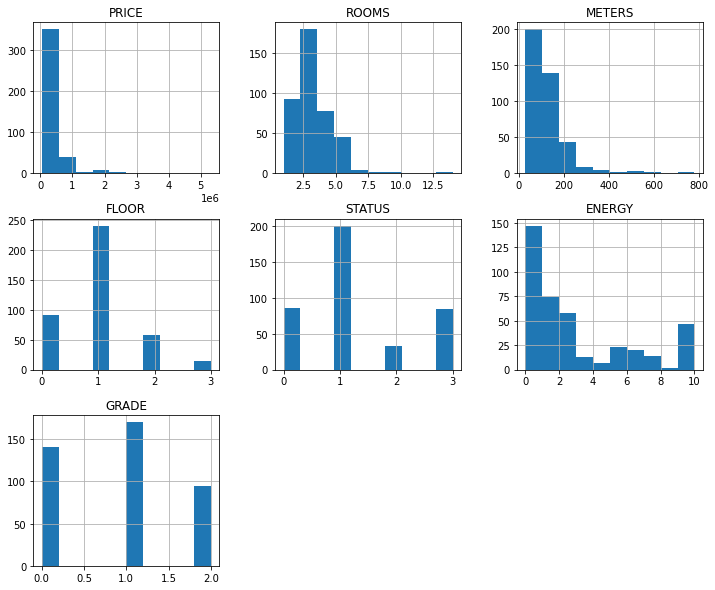

In [62]:
width=12
height=10
enc_houses_df[['PRICE', 'ROOMS', 'METERS', 'FLOOR', 'STATUS', 'ENERGY', 'GRADE']].hist(figsize=(width, height))
plt.show()

After plotting the histograms distributions of PRICE, ROOMS, METERS, FLOOR, STATUS, ENERGY and GRADE, it can be seen that:
1.	Most of houses prices are below 1000000 euros.
2.	Most of houses have from 1 to 4 rooms
3.	Most of houses have less than 200 square meters
4.	Most of houses have 1 floor
5.	Most of houses are in GOOD status
6.	Most of houses have a bed energy class

With these distributions, the models will probably have higher accuracy for houses with these characteristics and they will probably make more mistakes if the house is particularly big or it is a new construction.

Let's now do another reasoning. It is known that the price of an house is computed by multiplying the square meters by the square meter price of the house area. 

Since this relationship is known, it makes sense to create a new target variable: the square meter price. In this way the models will be trained to predict this variable instead of the price, removing the known relationship between price and square meters form the problem.

Let's add the new column to the dataframe.

In [63]:
# Create price for meter column
enc_houses_df['METER_PRICE'] = enc_houses_df['PRICE'] / enc_houses_df['METERS']
enc_houses_df.head()

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE
0,5317000,6 viale Cesare Battisti,5,542,3,0.0,2,1900,2.0,0.0,1.0,0.0,6.0,1,2.0,9809.963100
1,2970000,6 viale Cesare Battisti,4,295,3,1.0,2,1900,2.0,1.0,0.0,0.0,6.0,1,2.0,10067.796610
2,280000,3 via Ambrosini,3,115,2,1.0,1,1980,1.0,0.0,0.0,1.0,2.0,1,1.0,2434.782609
3,1050000,16 via Carlo Porta,5,278,3,1.0,2,1800,2.0,1.0,0.0,1.0,2.0,1,2.0,3776.978417
4,690000,1 via Bellini,5,220,3,1.0,1,1970,2.0,1.0,0.0,1.0,0.0,1,1.0,3136.363636


Let's now investigate if some correlation between features and target variable are particularly evident.

In [64]:
enc_houses_df.corr()

,PRICE,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE
PRICE,1.000000,0.632581,0.815492,0.624947,0.180533,0.403418,-0.137082,0.213596,0.319308,0.227843,0.202921,0.198592,-0.086223,0.416294,0.779530
ROOMS,0.632581,1.000000,0.809954,0.733998,0.302756,0.478725,-0.084634,0.103104,0.331869,0.237590,0.300530,0.075651,-0.037203,0.225216,0.396929
METERS,0.815492,0.809954,1.000000,0.732935,0.340850,0.545484,-0.121051,0.129925,0.357113,0.292050,0.301403,0.108804,-0.060365,0.244137,0.456480
BATHROOMS,0.624947,0.733998,0.732935,1.000000,0.308268,0.527754,0.067998,0.263536,0.426655,0.328107,0.354014,0.224414,-0.103821,0.417642,0.521526
FLOOR,0.180533,0.302756,0.340850,0.308268,1.000000,0.377229,0.042449,0.009617,0.352484,-0.062600,0.134896,-0.010004,-0.069226,0.021239,0.078401
FLOORS,0.403418,0.478725,0.545484,0.527754,0.377229,1.000000,-0.153199,-0.042837,0.190280,0.231414,0.228663,-0.062600,0.055239,0.085589,0.193277
YEAR,-0.137082,-0.084634,-0.121051,0.067998,0.042449,-0.153199,1.000000,0.523594,0.299443,0.061612,0.030242,0.620517,0.054554,0.249481,0.113841
STATUS,0.213596,0.103104,0.129925,0.263536,0.009617,-0.042837,0.523594,1.000000,0.423211,0.045723,-0.075035,0.796221,-0.064398,0.414762,0.474245
TERRACE,0.319308,0.331869,0.357113,0.426655,0.352484,0.190280,0.299443,0.423211,1.000000,0.041963,0.143026,0.401034,0.049062,0.387026,0.409888
GARDEN,0.227843,0.237590,0.292050,0.328107,-0.062600,0.231414,0.061612,0.045723,0.041963,1.000000,0.288523,0.029261,0.157398,0.209096,0.196940


As expected, the price is mostly correlated with meters, since that that the price is computed by multiplying square meters with square meters price.

We then see that the square meter price has highest correlation values with BATHROOMS, STATUS, METERS, TERRACE, ENERGY, ROOMS.

Surprisingly the bathrooms number seems to have higher impact than expected on square meter price.

Let's plot the scatterplots.

Text(0, 0.5, 'Meter price')

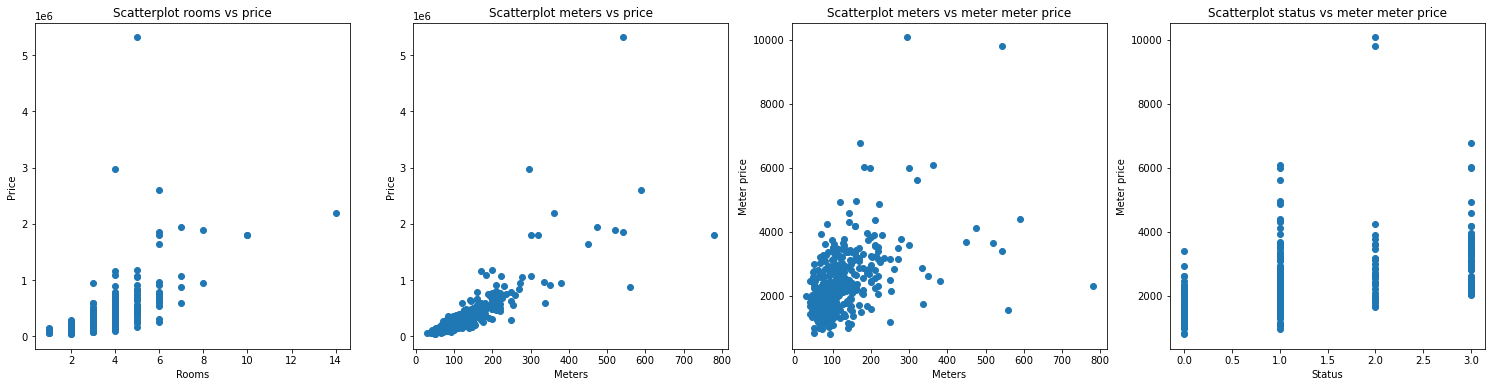

In [65]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(26, 6))
# Scatterplot rooms vs price
ax1.scatter(x=enc_houses_df['ROOMS'], y=enc_houses_df['PRICE'])
ax1.set_title('Scatterplot rooms vs price')
ax1.set_xlabel('Rooms')
ax1.set_ylabel('Price')
# Scatterplot meters vs price
ax2.scatter(x=enc_houses_df['METERS'], y=enc_houses_df['PRICE'])
ax2.set_title('Scatterplot meters vs price')
ax2.set_xlabel('Meters')
ax2.set_ylabel('Price')
# Scatterplot meter price vs meters
ax3.scatter(x=enc_houses_df['METERS'], y=enc_houses_df['METER_PRICE'])
ax3.set_title('Scatterplot meters vs meter meter price')
ax3.set_xlabel('Meters')
ax3.set_ylabel('Meter price')
# Scatterplot meter price vs status
ax4.scatter(x=enc_houses_df['STATUS'], y=enc_houses_df['METER_PRICE'])
ax4.set_title('Scatterplot status vs meter meter price')
ax4.set_xlabel('Status')
ax4.set_ylabel('Meter price')

It can be seen that the price spread increases with square meters, more and more if the square meters are over 300. The models will probably perform worse for those houses. 

It is also possible to see the presence of 2 outliers: one house with a price of more than 5 milions euros, far above than the average prices of the houses with the same characteristics. Also another house with a price of 3 milion euros is quite far from the average price of the similar houses.

Their price is probably a mistake or it is due to very particular characteristics that are not captured by the selected features.

For this reason, let's remove them from the dataset.

In [66]:
# Drop rows with price higher then 2900000 euros
enc_houses_df = enc_houses_df.drop(index=enc_houses_df[enc_houses_df['PRICE'] > 2900000].index).reset_index(drop=True)
enc_houses_df

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE
0,280000,3 via Ambrosini,3,115,2,1.0,1,1980,1.0,0.0,0.0,1.0,2.0,1,1.0,2434.782609
1,1050000,16 via Carlo Porta,5,278,3,1.0,2,1800,2.0,1.0,0.0,1.0,2.0,1,2.0,3776.978417
2,690000,1 via Bellini,5,220,3,1.0,1,1970,2.0,1.0,0.0,1.0,0.0,1,1.0,3136.363636
3,950000,14 via Sant'Andrea,3,272,3,0.0,1,2020,3.0,0.0,1.0,1.0,9.0,1,1.0,3492.647059
4,450000,35 via Aliprandi Pinalla,3,145,1,2.0,1,1890,2.0,0.0,0.0,1.0,0.0,1,1.0,3103.448276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,75000,8 viale Lombardia,2,63,1,1.0,1,1950,0.0,0.0,0.0,0.0,0.0,9,0.0,1190.476190
399,145000,6 via Teano,3,76,1,0.0,1,1960,2.0,0.0,0.0,0.0,3.0,9,0.0,1907.894737
400,340000,13 via Francesco Guerrazzi,3,118,2,0.0,1,2015,2.0,0.0,1.0,0.0,6.0,9,1.0,2881.355932
401,159000,via Molise,2,80,1,0.0,2,1950,1.0,1.0,0.0,0.0,0.0,9,0.0,1987.500000


Now as next step, the goal is to investigate spatial information from the houses.

With che use of geopy and ArcGIS as geolocator, it is possible to retrieve latitudes and longitudes coordinates for each house using the address.

Let's define a function for this task, so that it can be used also to preprocess the test set later on.

In [67]:
# Define a function to geocode the address in a dataframe, so that we can apply che process to the house test set later on.
def geocode_dataframe(houses_dataframe):
    # We use ArcGIS because Nominatim doesn't work with house number in Monza.
    geolocator = gc.ArcGIS(user_agent="monza_explorer")
    # Add latitude and longitude columns to the dataframe
    houses_dataframe[['LAT', 'LNG']] = 0.0
    # Get latitude and longitue for each house
    for idx in range(len(houses_dataframe)):
        coordinates = geolocator.geocode("{}, Monza, IT".format(houses_dataframe.loc[idx, 'ADDRESS']))
        houses_dataframe.loc[idx, 'LAT'] = coordinates.latitude
        houses_dataframe.loc[idx, 'LNG'] = coordinates.longitude
    return houses_dataframe

In [68]:
# Call geocode function to retrieve latitudes and longitues. This will take a while...
enc_houses_df = geocode_dataframe(enc_houses_df)
enc_houses_df.head()

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE,LAT,LNG
0,280000,3 via Ambrosini,3,115,2,1.0,1,1980,1.0,0.0,0.0,1.0,2.0,1,1.0,2434.782609,45.60266,9.26639
1,1050000,16 via Carlo Porta,5,278,3,1.0,2,1800,2.0,1.0,0.0,1.0,2.0,1,2.0,3776.978417,45.58266,9.27903
2,690000,1 via Bellini,5,220,3,1.0,1,1970,2.0,1.0,0.0,1.0,0.0,1,1.0,3136.363636,45.59647,9.27031
3,950000,14 via Sant'Andrea,3,272,3,0.0,1,2020,3.0,0.0,1.0,1.0,9.0,1,1.0,3492.647059,45.59982,9.26604
4,450000,35 via Aliprandi Pinalla,3,145,1,2.0,1,1890,2.0,0.0,0.0,1.0,0.0,1,1.0,3103.448276,45.58688,9.27912


In [69]:
#Let's see if some lat or lng are not consistent
enc_houses_df[['LAT', 'LNG']].describe()

,LAT,LNG
count,403.000000,403.000000
mean,45.581052,9.271413
std,0.010591,0.019657
min,45.555490,9.231720
25%,45.573945,9.257095
50%,45.580360,9.268230
75%,45.589261,9.287084
max,45.604134,9.318320


Now that the coordinates has been retrieved, it is possilbe to plot the houses using folium.

Let's assign a different color depending on the neighborhood and a CircleMarker dimension proportional to the square meter price.

In [70]:
# Create Monza map with folium using Monza's nominal coordinates
MONZA_COORDINATES = [45.5804, 9.2759]
monza_map = folium.Map(location=MONZA_COORDINATES, zoom_start=14)
# Define colors for each neighborhood
house_colors = {1:'#ff0000', 2:'#707070', 3:'#00b000', 4:'#993333', 5:'#aa7878', 6:'#000000', 7:'#0000aa', 8:'#505050', 9:'#b056a5'}
# Add all the houses to the map, set radius dimension depending on radius
for lat, lng, price, address, met_price, neighborhood in zip(enc_houses_df['LAT'], 
                                                             enc_houses_df['LNG'], 
                                                             enc_houses_df['PRICE'], 
                                                             enc_houses_df['ADDRESS'], 
                                                             enc_houses_df['METER_PRICE'], 
                                                             enc_houses_df['NEIGHBORHOOD']):
    # Set label as "address; price"
    label = folium.Popup("{}; {}".format(address, price), parse_html=True)
    # Set circle radius to be proportional to meter price, with maximum radius of 5 and with different color for neighborhoods
    folium.CircleMarker(
        [lat, lng],
        radius=10 * (met_price / np.max(enc_houses_df['METER_PRICE'])),
        weight=1,
        popup=label,
        color=house_colors[neighborhood],
        fill=True,
        fill_color=house_colors[neighborhood],
        fill_opacity=1,
        parse_html=False).add_to(monza_map)  
monza_map

After plotting it can be seen that:
1.	Houses have a good distribution around Monza territory
2.	Houses with highest meter prices are in or around the historical center.
3.	The neighborhood feature present in the dataset is not precise. 
In fact, there are different houses that have been mistakenly categorized: it is possible to see some “red” houses, that should correspond to the “center” neighborhood, that are quite far away from the center. The same happens with “blue” and “black” neighborhoods.

## Cluster neighborhoods <a name="cluster"></a>

After having ascertained that the actual feature present in the dataset is not precise and thus it cannot be used as feature for the problem, it could be possible to perform a K-Means clustering by using latitude and longitude coordinates.

Let's grid search the number of clusters from 2 to 15 and plot the inertia score.

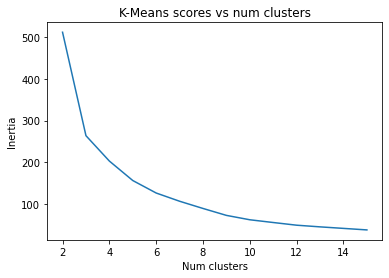

In [71]:
# First normalize data with standard scaler
clust_scaler = StandardScaler()
X_clust = clust_scaler.fit_transform(enc_houses_df[["LAT", "LNG"]])
# Let's perform K-means clustering, try to how can we choose the number of clusters
n_clusters = np.linspace(2, 15, 13).astype(int)
scores = []
km_list = []
for n_clust in n_clusters:
    km = KMeans(n_clusters=n_clust, random_state=0, n_init=20).fit(X_clust)
    km_list.append(km)
    scores.append(km.inertia_)
# Plot scores 
plt.plot(n_clusters, scores)
plt.title("K-Means scores vs num clusters")
plt.xlabel("Num clusters")
plt.ylabel("Inertia")
plt.show()

Let's choose 10 clusters and add the obtained clusters as a new column to the dataframe.

In [72]:
# Add predicted labels to houses dataset
#enc_houses_df.insert(14, "CLUSTER", km_list[2].labels_)
enc_houses_df["CLUSTER"] = km_list[8].labels_
enc_houses_df

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE,LAT,LNG,CLUSTER
0,280000,3 via Ambrosini,3,115,2,1.0,1,1980,1.0,0.0,0.0,1.0,2.0,1,1.0,2434.782609,45.602660,9.266390,2
1,1050000,16 via Carlo Porta,5,278,3,1.0,2,1800,2.0,1.0,0.0,1.0,2.0,1,2.0,3776.978417,45.582660,9.279030,8
2,690000,1 via Bellini,5,220,3,1.0,1,1970,2.0,1.0,0.0,1.0,0.0,1,1.0,3136.363636,45.596470,9.270310,2
3,950000,14 via Sant'Andrea,3,272,3,0.0,1,2020,3.0,0.0,1.0,1.0,9.0,1,1.0,3492.647059,45.599820,9.266040,2
4,450000,35 via Aliprandi Pinalla,3,145,1,2.0,1,1890,2.0,0.0,0.0,1.0,0.0,1,1.0,3103.448276,45.586880,9.279120,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,75000,8 viale Lombardia,2,63,1,1.0,1,1950,0.0,0.0,0.0,0.0,0.0,9,0.0,1190.476190,45.589430,9.253060,9
399,145000,6 via Teano,3,76,1,0.0,1,1960,2.0,0.0,0.0,0.0,3.0,9,0.0,1907.894737,45.568350,9.251030,0
400,340000,13 via Francesco Guerrazzi,3,118,2,0.0,1,2015,2.0,0.0,1.0,0.0,6.0,9,1.0,2881.355932,45.571300,9.264310,3
401,159000,via Molise,2,80,1,0.0,2,1950,1.0,1.0,0.0,0.0,0.0,9,0.0,1987.500000,45.573006,9.256721,4


And at last let's plot the obteined clusters with folium to see the differences with respect to the initial division.

In [73]:
# Create Monza map with folium using Monza's nominal coordinates
monza_map = folium.Map(location=MONZA_COORDINATES, zoom_start=14)
# Define colors for each neighborhood
house_colors = ['#ff0000', '#707070', '#00b000', '#993333', '#aa7878', '#000000', '#0000aa', '#505050', '#b056a5', '#0000ff']
# Add all the houses to the map, set radius dimension depending on radius
for lat, lng, price, address, met_price, cluster in zip(enc_houses_df['LAT'], 
                                                             enc_houses_df['LNG'], 
                                                             enc_houses_df['PRICE'], 
                                                             enc_houses_df['ADDRESS'], 
                                                             enc_houses_df['METER_PRICE'], 
                                                             enc_houses_df['CLUSTER']):
    # Set label as "address; price; cluster"
    label = folium.Popup("{}; {}; {}".format(address, price, cluster), parse_html=True)
    # Set circle radius to be proportional to meter price, with maximum radius of 5 and with different color for neighborhoods
    folium.CircleMarker(
        [lat, lng],
        radius=10 * (met_price / np.max(enc_houses_df['METER_PRICE'])),
        weight=1,
        popup=label,
        color=house_colors[cluster],
        fill=True,
        fill_color=house_colors[cluster],
        fill_opacity=1,
        parse_html=False).add_to(monza_map)  
monza_map

Now the houses division better reflects the real neighborhoods division, so it can be used as a new feature for the regression analysis.

Let's now explore how the information retrieved by Foursquare API can be used for the problem.

## Usage of foursquare API <a name="foursquare"></a>

The idea is to retrieve the 30 top trend venues in Monza then, for each house, determine which of those are present in the immediate vicinity of the house.

Therefore, 30 features there will be added, one for each venue, and each house will have 1 or 0 to the i-th feature depending if the i-th venue is present or absent in the surroundings of the house.

Foursquare API will be called setting sortByPopularity parameter to 1, and section parameter to topPicks.

As before, let's define functions to automate the task.

In [74]:
# Function that returns the foursquare url around a specified radius. 
def getFoursquareUrl(coordinates, radius):
    # Connection data to foursqare API
    CLIENT_ID = 'WU0OFAD5X0E4SKHNZHFF51VGBFLB1D4ZFQYVNRYBTVL4Z3HE' # Foursquare ID
    CLIENT_SECRET = 'NPAWDVFOVL5XZHSU5ISMB1PXTKGDCN4N1Q0WWPOTOKLGHILY' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    lat=coordinates[0] # Latitude
    lng=coordinates[1] # Longitude
    LIMIT = 30 # We search for the top 20 venues
    # We call the venues/explore endpoint, with sortByPopularity set to 1 and section set to topPicks
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity=1&llAcc=1&section=topPicks'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    return url

# Function that returns a dataframe of the top 30 trending venue given latitude and longitude
# Let's set the default radius to 700.
def getVenues(coordinates, radius=700):
    # Call foursquare api
    url = getFoursquareUrl(coordinates, radius)
    foursquare_results = requests.get(url).json()
    # Parse the result saving into a pandas dataframe
    venues = foursquare_results['response']['groups'][0]['items']
    venues_df = pd.json_normalize(venues)
    # Return venues names removing duplicates because Foursquare can contains duplicate names
    return venues_df['venue.name'].drop_duplicates(keep=False).values

# Define a function to get the top trending 30 venues around each house
def getHousesVenues(houses_dataframe):
    # Each column name correspond to the name of the venue, so get all venues using columns (start from 3rd column because first two are LAT and LNG)
    monza_30venues = houses_dataframe.columns[2:]
    # Iterate over the rows of the dataset
    for idx in range(len(houses_dataframe)):
        # Call foursquare and get venues for the actual house coordinates
        coordinates = [houses_dataframe.loc[idx, 'LAT'], houses_dataframe.loc[idx, 'LNG']]
        house_venues = getVenues(coordinates)
        # Add venues presence to the dataset: set i-th column to 1 if the i-th venue has been found
        houses_dataframe.iloc[idx, 2:] = [1 if venue in house_venues else 0 for venue in monza_30venues]
    # Return filled dataset
    return houses_dataframe

Let's now create the houses venues dataframe by calling foursquare and adding the venues features and then fill the dataframe by calling the created function.

In [75]:
# First, get the 30 top trend venues in monza and add them as columns to the dataframe.
# The venues have been previously searched with a radius of 2500
#monza_30top_venues = getVenues(MONZA_COORDINATES, radius=2500)
monza_30top_venues = load("monza_top_venues.joblib")
# Then, add the found venues as columns in the dataframe
houses_venues_df=enc_houses_df[['LAT', 'LNG']].append(pd.DataFrame(columns = monza_30top_venues))
houses_venues_df.fillna(value=0, inplace=True)
houses_venues_df.head()

,LAT,LNG,Villa Reale,Piazza Trento e Trieste,Istituti Clinici Zucchi,Parco di Monza - Ingresso Alle Grazie,U2,Parco di Monza - Viale cavriga,Dori,Civico 1,La Rinascente,Duomo di Monza,Macellerie Monzesi,La Feltrinelli,Alcott,Piazza Carrobiolo,Roseto della Villa Reale,Pasticceria Viganò,Moderno Pasticceria Confetteria,Monzello,Le dolcezze di Mister C,Rondò dei Pini,Tearose Cafè,Serrone della Villa Reale,Teatro Manzoni,Coco Le Patissier,Osteria Bacco e Tabacco,Derby Grill,Exfactory,Nespresso Boutique
0,45.60266,9.26639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,45.58266,9.27903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,45.59647,9.27031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,45.59982,9.26604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,45.58688,9.27912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
# Now, call the function to fill the venue presence for each house
houses_venues_df = getHousesVenues(houses_venues_df)
houses_venues_df.head()

,LAT,LNG,Villa Reale,Piazza Trento e Trieste,Istituti Clinici Zucchi,Parco di Monza - Ingresso Alle Grazie,U2,Parco di Monza - Viale cavriga,Dori,Civico 1,La Rinascente,Duomo di Monza,Macellerie Monzesi,La Feltrinelli,Alcott,Piazza Carrobiolo,Roseto della Villa Reale,Pasticceria Viganò,Moderno Pasticceria Confetteria,Monzello,Le dolcezze di Mister C,Rondò dei Pini,Tearose Cafè,Serrone della Villa Reale,Teatro Manzoni,Coco Le Patissier,Osteria Bacco e Tabacco,Derby Grill,Exfactory,Nespresso Boutique
0,45.60266,9.26639,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,45.58266,9.27903,0,1,1,0,0,0,1,0,1,1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1
2,45.59647,9.27031,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,45.59982,9.26604,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,45.58688,9.27912,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1


Let's now try to use the obtained features to perform again K-Means clustering to check how the neighborhood division changes.

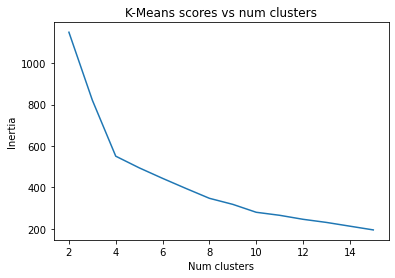

In [77]:
X_clust = houses_venues_df.copy()
# First normalize data with standard scaler
clust_scaler = StandardScaler()
X_clust[["LAT", "LNG"]] = clust_scaler.fit_transform(X_clust[["LAT", "LNG"]])
# Let's perform K-means clustering, try to how can we choose the number of clusters
n_clusters = np.linspace(2, 15, 13).astype(int)
scores = []
km_list = []
for n_clust in n_clusters:
    km = KMeans(n_clusters=n_clust, random_state=0, n_init=20).fit(X_clust)
    km_list.append(km)
    scores.append(km.inertia_)
# Plot scores 
plt.plot(n_clusters, scores)
plt.title("K-Means scores vs num clusters")
plt.xlabel("Num clusters")
plt.ylabel("Inertia")
plt.show()

The performance, considering inertia, has a similar trend with respect to previous clustering, but with higher values.

Let's add the obtained cluster venues column to the dataframe.

In [78]:
# Add predicted labels to houses dataset
#enc_houses_df.insert(15, "CLUSTER_VENUES", km_list[2].labels_)
enc_houses_df["CLUSTER_VENUES"] = km_list[8].labels_
enc_houses_df

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE,LAT,LNG,CLUSTER,CLUSTER_VENUES
0,280000,3 via Ambrosini,3,115,2,1.0,1,1980,1.0,0.0,0.0,1.0,2.0,1,1.0,2434.782609,45.602660,9.266390,2,6
1,1050000,16 via Carlo Porta,5,278,3,1.0,2,1800,2.0,1.0,0.0,1.0,2.0,1,2.0,3776.978417,45.582660,9.279030,8,2
2,690000,1 via Bellini,5,220,3,1.0,1,1970,2.0,1.0,0.0,1.0,0.0,1,1.0,3136.363636,45.596470,9.270310,2,4
3,950000,14 via Sant'Andrea,3,272,3,0.0,1,2020,3.0,0.0,1.0,1.0,9.0,1,1.0,3492.647059,45.599820,9.266040,2,6
4,450000,35 via Aliprandi Pinalla,3,145,1,2.0,1,1890,2.0,0.0,0.0,1.0,0.0,1,1.0,3103.448276,45.586880,9.279120,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,75000,8 viale Lombardia,2,63,1,1.0,1,1950,0.0,0.0,0.0,0.0,0.0,9,0.0,1190.476190,45.589430,9.253060,9,6
399,145000,6 via Teano,3,76,1,0.0,1,1960,2.0,0.0,0.0,0.0,3.0,9,0.0,1907.894737,45.568350,9.251030,0,1
400,340000,13 via Francesco Guerrazzi,3,118,2,0.0,1,2015,2.0,0.0,1.0,0.0,6.0,9,1.0,2881.355932,45.571300,9.264310,3,3
401,159000,via Molise,2,80,1,0.0,2,1950,1.0,1.0,0.0,0.0,0.0,9,0.0,1987.500000,45.573006,9.256721,4,1


At last, let's plot again the houses with the new clusters.

In [79]:
# Create Monza map with folium using Monza's nominal coordinates
monza_map = folium.Map(location=MONZA_COORDINATES, zoom_start=14)
# Define colors for each neighborhood
house_colors = ['#ff0000', '#707070', '#00b000', '#993333', '#aa7878', '#000000', '#0000aa', '#505050', '#b056a5', '#0000ff', '#990000']
# Add all the houses to the map, set radius dimension depending on radius
for lat, lng, price, address, met_price, cluster in zip(enc_houses_df['LAT'], 
                                                             enc_houses_df['LNG'], 
                                                             enc_houses_df['PRICE'], 
                                                             enc_houses_df['ADDRESS'], 
                                                             enc_houses_df['METER_PRICE'], 
                                                             enc_houses_df['CLUSTER_VENUES']):
    # Set label as "address; price; cluster"
    label = folium.Popup("{}; {}; {}".format(address, price, cluster), parse_html=True)
    # Set circle radius to be proportional to meter price, with maximum radius of 5 and with different color for neighborhoods
    folium.CircleMarker(
        [lat, lng],
        radius=10 * (met_price / np.max(enc_houses_df['METER_PRICE'])),
        weight=1,
        popup=label,
        color=house_colors[cluster],
        fill=True,
        fill_color=house_colors[cluster],
        fill_opacity=1,
        parse_html=False).add_to(monza_map)  
monza_map

The clustering performed with the venues features brought to a different neighborhood division.

This time, the clustering has divided the houses in the center from the houses just around the center, obtaining smaller clusters in the area.
Instead, the model lost the division of the peripheral neighborhoods obtaining in that case bigger clusters.
This can probably be acceptable, since the peripheral neighborhoods have lower impact on square meter price.

In the next section both features will be tested to check which will have better performance.

## Regression: training models <a name="training"></a>

Before proceed to the training phase of the regression models, as final step let's perform a different encoding of the FLOOR feature.

With the ordinal encoding, in fact, it seems that this feature is not really correlated to the square meter price, as seen in [Data loading and preprocessing](#data) section.

This is something unexpected since, usually, houses at higher floors have also a higher cost with respect to houses at lowest floors.

For this reason, let's perform a different encoding creating three new columns namely GROUND, MIDDLE and LAST, that will be populated basing on the values of FLOOR and FLOORS features.

In particular, if a house have a GROUND floor let's set the GROUND column to 1, and the MIDDLE and LAST columns depending on how many FLOORS are present, and perform this reasoning also for MIDDLE and LAST. If there is a VILLA, instead, let's set all of the three columns to 1.

Again, let's define a function to do this, then encode the houses dataset.

In [80]:
# Define the function to perform the floors encoding
def encodeFloors(houses_df):
    # First add the new columns to the dataframe
    houses_df.insert(7, column="LAST", value=0)
    houses_df.insert(7, column="MIDDLE", value=0)
    houses_df.insert(7, column="GROUND", value=0)
    # Then iterate all rows in the dataframe
    for idx in range(len(houses_df)):
        # Set GROUND column depending on floor and floors
        if  (
            (houses_df.loc[idx, "FLOOR"] == 0) or (houses_df.loc[idx, "FLOOR"] == 3) or 
            (houses_df.loc[idx, "FLOORS"] > 2) or 
            ((houses_df.loc[idx, "FLOOR"] == 1) and (houses_df.loc[idx, "FLOORS"] > 1))
        ):
            # Set value
            houses_df.loc[idx, "GROUND"] = 1
                                  
        # Set MIDDLE column depending on floor and floors
        if  (
            (houses_df.loc[idx, "FLOOR"] == 1) or (houses_df.loc[idx, "FLOOR"] == 3) or
            (houses_df.loc[idx, "FLOORS"] > 2) or 
            ((houses_df.loc[idx, "FLOOR"] != 1) and (houses_df.loc[idx, "FLOORS"] > 1))
        ):
            # Set value
            houses_df.loc[idx, "MIDDLE"] = 1
                                  
        # Set MIDDLE column depending on floor and floors
        if  (
            (houses_df.loc[idx, "FLOOR"] == 2) or (houses_df.loc[idx, "FLOOR"] == 3) or 
            (houses_df.loc[idx, "FLOORS"] > 2)
        ):
            # Set value
            houses_df.loc[idx, "LAST"] = 1
    # Return modified dataframe
    return houses_df        

In [81]:
# Call the function to encode the dataframe
enc_houses_df = encodeFloors(enc_houses_df)
enc_houses_df.head()

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,GROUND,MIDDLE,LAST,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE,LAT,LNG,CLUSTER,CLUSTER_VENUES
0,280000,3 via Ambrosini,3,115,2,1.0,1,0,1,0,1980,1.0,0.0,0.0,1.0,2.0,1,1.0,2434.782609,45.60266,9.26639,2,6
1,1050000,16 via Carlo Porta,5,278,3,1.0,2,1,1,0,1800,2.0,1.0,0.0,1.0,2.0,1,2.0,3776.978417,45.58266,9.27903,8,2
2,690000,1 via Bellini,5,220,3,1.0,1,0,1,0,1970,2.0,1.0,0.0,1.0,0.0,1,1.0,3136.363636,45.59647,9.27031,2,4
3,950000,14 via Sant'Andrea,3,272,3,0.0,1,1,0,0,2020,3.0,0.0,1.0,1.0,9.0,1,1.0,3492.647059,45.59982,9.26604,2,6
4,450000,35 via Aliprandi Pinalla,3,145,1,2.0,1,0,0,1,1890,2.0,0.0,0.0,1.0,0.0,1,1.0,3103.448276,45.58688,9.27912,8,9


Let's now check how the features are now correlated.

In [82]:
enc_houses_df[["PRICE", "METER_PRICE", "FLOOR", "FLOORS", "GROUND", "MIDDLE", "LAST"]].corr()

,PRICE,METER_PRICE,FLOOR,FLOORS,GROUND,MIDDLE,LAST
PRICE,1.000000,0.713004,0.290508,0.455939,0.177458,0.061714,0.344102
METER_PRICE,0.713004,1.000000,0.118863,0.169294,0.055911,-0.033399,0.204556
FLOOR,0.290508,0.118863,1.000000,0.384436,-0.446524,0.297279,0.737765
FLOORS,0.455939,0.169294,0.384436,1.000000,0.399277,0.246873,0.519894
GROUND,0.177458,0.055911,-0.446524,0.399277,1.000000,-0.500482,-0.049390
MIDDLE,0.061714,-0.033399,0.297279,0.246873,-0.500482,1.000000,-0.204086
LAST,0.344102,0.204556,0.737765,0.519894,-0.049390,-0.204086,1.000000


The highest correlated of the new features is LAST, even if with still a low value it is higher than using the FLOOR feature before encoding, so it will be used insted of the others.

Now it is time to create the 4 features sets that will be used:

- **Dataset #1**: this will be the original encoded dataset with the following features: ROOMS, METERS, BATHROOMS, LAST, YEAR, STATUS, TERRACE, GARDEN, GARAGE, ENERGY
- **Dataset #2**: this will be Dataset #1 + the CLUSTER columns, that is the neighborhood division made with K-Means using latitude and longitudes.
- **Dataset #3**: this will be Dataset #1 + the CLUSTER_VENUES columns, that is the neighborhood division made with K-Means using venues features retrieved with Foursquare.
- **Dataset #4**: this will be Dataset #1 + the venues features retrieved with Foursquare.

All dataset will be standardazied with StandardScaler.

The target variable will be METER_PRICE.

Let's create the 4 training datasets:

In [83]:
# Define common features and target variable
features = ["ROOMS", "METERS", "BATHROOMS", "LAST", "YEAR", "STATUS", "TERRACE", "GARDEN", "GARAGE", "ENERGY"]
y_train = enc_houses_df["METER_PRICE"]
# Prepare dataset 1
st_scaler1 = StandardScaler()
X_train1 = st_scaler1.fit_transform(enc_houses_df[features])
# Prepare dataset 2
st_scaler2 = StandardScaler()
X_train2 = st_scaler2.fit_transform(enc_houses_df[features + ["CLUSTER"]])
# Prepare dataset 3
st_scaler3 = StandardScaler()
X_train3 = st_scaler3.fit_transform(enc_houses_df[features + ["CLUSTER_VENUES"]])
# Prepare dataset 4
features_df4 = pd.concat(objs=[enc_houses_df[features], houses_venues_df.iloc[:, 2:]], axis=1)
st_scaler4 = StandardScaler()
X_train4 = st_scaler4.fit_transform(features_df4)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jupyterlab/conda/env

#### Multivariate Linear Regression

The first model to train is Multivariate Linear Regression. Let's train the models with the 4 datasets and evaluate R2 and RMSE on training set.

In [84]:
# For each dataset, train the model then obtain predictions and compute MSE with R2
# -- Dataset 1
lr1 = LinearRegression().fit(X_train1, y_train)
# R2
score_lr1 = lr1.score(X_train1, y_train)
# RMSE
y_train_hat_lr1 = lr1.predict(X_train1)
rmse_lr1 = np.sqrt(mean_squared_error(y_train, y_train_hat_lr1))
# -- Dataset 2
# Train the model
lr2 = LinearRegression().fit(X_train2, y_train)
# R2
score_lr2 = lr2.score(X_train2, y_train)
# RMSE
y_train_hat_lr2 = lr2.predict(X_train2)
rmse_lr2 = np.sqrt(mean_squared_error(y_train, y_train_hat_lr2))
# -- Dataset 3
# Train the model
lr3 = LinearRegression().fit(X_train3, y_train)
# R2
score_lr3 = lr3.score(X_train3, y_train)
# RMSE
y_train_hat_lr3 = lr3.predict(X_train3)
rmse_lr3 = np.sqrt(mean_squared_error(y_train, y_train_hat_lr3))
# -- Dataset 4
# Train the model
lr4 = LinearRegression().fit(X_train4, y_train)
# R2
score_lr4 = lr4.score(X_train4, y_train)
# RMSE
y_train_hat_lr4 = lr4.predict(X_train4)
rmse_lr4 = np.sqrt(mean_squared_error(y_train, y_train_hat_lr4))
# -- Print scores
print("Linear Model, dataset 1 score: {}; RMSE: {}".format(score_lr1, rmse_lr1))
print("Linear Model, dataset 2 score: {}; RMSE: {}".format(score_lr2, rmse_lr2))
print("Linear Model, dataset 3 score: {}; RMSE: {}".format(score_lr3, rmse_lr3))
print("Linear Model, dataset 4 score: {}; RMSE: {}".format(score_lr4, rmse_lr4))

Linear Model, dataset 1 score: 0.4968208128335934; RMSE: 643.610516655727
Linear Model, dataset 2 score: 0.502975782030624; RMSE: 639.6620309086717
Linear Model, dataset 3 score: 0.5057007041623428; RMSE: 637.9061558817966
Linear Model, dataset 4 score: 0.6386949847912484; RMSE: 545.3794784456504


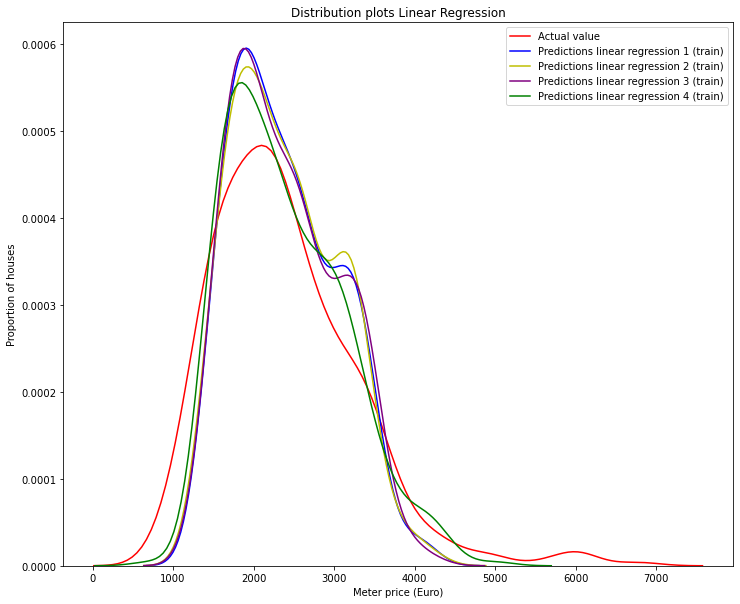

In [85]:
# -- Plot distributions plots
plt.figure(figsize=(width, height))
ax1 = seaborn.distplot(y_train, hist=False, color="r", label="Actual value")
seaborn.distplot(y_train_hat_lr1, hist=False, color="b", label="Predictions linear regression 1 (train)", ax=ax1)
seaborn.distplot(y_train_hat_lr2, hist=False, color="y", label="Predictions linear regression 2 (train)", ax=ax1)
seaborn.distplot(y_train_hat_lr3, hist=False, color="purple", label="Predictions linear regression 3 (train)", ax=ax1)
seaborn.distplot(y_train_hat_lr4, hist=False, color="g", label="Predictions linear regression 4 (train)", ax=ax1)
plt.title("Distribution plots Linear Regression")
plt.xlabel('Meter price (Euro)')
plt.ylabel('Proportion of houses')
plt.show()

As expected, the first dataset without spatial information is the worst performing one, even if not so far from datasets #2 and #3, that almost have the same results. So clustering performed with the venues features is not having a tangible impact on the models performances

The 4th dataset, instead, is having better performances. Therefore it seems that using the venues features directly in the training dataset, allows to obtain better results. We will see if these results will be confirmed with the other models.

Regarding the distribution of the house prices, it is possible to see that the training dataset has an average square meter price around 2000 euros, there is also what seems to be a non linearity around 6000 euros.
Multivariate linear regression was not able to predict prices higher then 5000 euros, and there is also a strange behavior for prices around 3000 euros.

In conclusion, Multivariate Linear Regression is not having good performances. Let's try a more complex model.

#### Ridge regression with polynomial features

In order to perform a non linear regression, let's perform a Polynomial transformations on the feature sets, by using 3rd degree polynomial.

In [86]:
# Obtain polynomial features
deg = 3
# -- Dataset 1
pf1 = PolynomialFeatures(degree=deg)
X_train1_pf = pf1.fit_transform(X_train1)
# -- Dataset 2
pf2 = PolynomialFeatures(degree=deg)
X_train2_pf = pf2.fit_transform(X_train2)
# -- Dataset 3
pf3 = PolynomialFeatures(degree=deg)
X_train3_pf = pf3.fit_transform(X_train3)
# -- Dataset 4
pf4 = PolynomialFeatures(degree=deg)
X_train4_pf = pf4.fit_transform(X_train4)

Since that this model is more complex, let's perform a grid search on the alpha parameter to retrieve the most performin model. The grid search will create models with the following values of alpha: 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000.

To control overfitting, it will be performed a 5 fold cross validation training process.

Let's use sklearn GridSearchCV to automate the task.

In [87]:
# Create alphas for Grid Search CV
alphas_rr = [{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}]
# -- Rige Regression dataset 1
gscv_rr1 = GridSearchCV(Ridge(random_state=0), alphas_rr, cv=5).fit(X_train1_pf, y_train)
# R2
score_rr1 = gscv_rr1.best_estimator_.score(X_train1_pf, y_train)
# RMSE
y_train_hat_rr1 = gscv_rr1.best_estimator_.predict(X_train1_pf)
rmse_rr1 = np.sqrt(mean_squared_error(y_train, y_train_hat_rr1))
# -- Rige Regression dataset 2
gscv_rr2 = GridSearchCV(Ridge(random_state=0), alphas_rr, cv=5).fit(X_train2_pf, y_train)
# R2
score_rr2 = gscv_rr2.best_estimator_.score(X_train2_pf, y_train)
# RMSE
y_train_hat_rr2 = gscv_rr2.best_estimator_.predict(X_train2_pf)
rmse_rr2 = np.sqrt(mean_squared_error(y_train, y_train_hat_rr2))
# -- Rige Regression dataset 3
gscv_rr3 = GridSearchCV(Ridge(random_state=0), alphas_rr, cv=5).fit(X_train3_pf, y_train)
# R2
score_rr3 = gscv_rr3.best_estimator_.score(X_train3_pf, y_train)
# RMSE
y_train_hat_rr3 = gscv_rr3.best_estimator_.predict(X_train3_pf)
rmse_rr3 = np.sqrt(mean_squared_error(y_train, y_train_hat_rr3))
# -- Rige Regression dataset 4
gscv_rr4 = GridSearchCV(Ridge(random_state=0), alphas_rr, cv=5).fit(X_train4_pf, y_train)
# R2
score_rr4 = gscv_rr4.best_estimator_.score(X_train4_pf, y_train)
# RMSE
y_train_hat_rr4 = gscv_rr4.best_estimator_.predict(X_train4_pf)
rmse_rr4 = np.sqrt(mean_squared_error(y_train, y_train_hat_rr4))
# -- Print scores
print("Ridge regression model, dataset 1 score: {}; RMSE: {}".format(score_rr1, rmse_rr1))
print("Ridge regression model, dataset 2 score: {}; RMSE: {}".format(score_rr2, rmse_rr2))
print("Ridge regression model, dataset 3 score: {}; RMSE: {}".format(score_rr3, rmse_rr3))
print("Ridge regression model, dataset 4 score: {}; RMSE: {}".format(score_rr4, rmse_rr4))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python

Ridge regression model, dataset 1 score: 0.44643663603464323; RMSE: 675.064806376489
Ridge regression model, dataset 2 score: 0.4721543198272843; RMSE: 659.1970924437838
Ridge regression model, dataset 3 score: 0.46890082931241023; RMSE: 661.2255231926644
Ridge regression model, dataset 4 score: 0.774572005902006; RMSE: 430.79010633130264


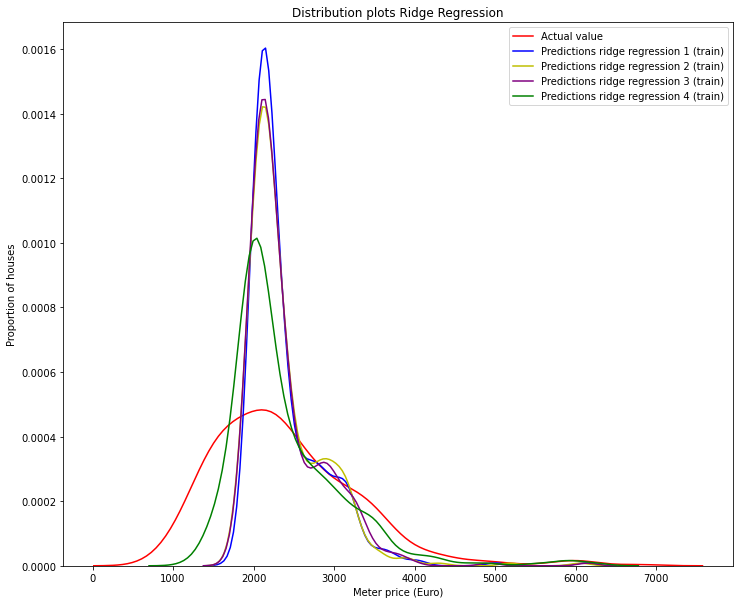

In [88]:
# -- Plot distributions plots
plt.figure(figsize=(width, height))
ax1 = seaborn.distplot(y_train, hist=False, color="r", label="Actual value")
seaborn.distplot(y_train_hat_rr1, hist=False, color="b", label="Predictions ridge regression 1 (train)", ax=ax1)
seaborn.distplot(y_train_hat_rr2, hist=False, color="y", label="Predictions ridge regression 2 (train)", ax=ax1)
seaborn.distplot(y_train_hat_rr3, hist=False, color="purple", label="Predictions ridge regression 3 (train)", ax=ax1)
seaborn.distplot(y_train_hat_rr4, hist=False, color="g", label="Predictions ridge regression 4 (train)", ax=ax1)
plt.title("Distribution plots Ridge Regression")
plt.xlabel('Meter price (Euro)')
plt.ylabel('Proportion of houses')
plt.show()

It can be seen that the models using the first 3 dataset are not having benefit from the polynomial transformation. Their performance, in fact, is even lower then the Multivariate Linear Regression model.

Different is the case of dataset #4. The model using this dataset, in fact, is obtaining a boost in the performance by using Ridge Regression with Polynomial transformation. The model is also better predicting prices in the critical range of 5000-7000 euros. However, it is committing more mistakes in the 1000-3000 range, predicting too many prices as 2000.

Let's try another model.

#### Support Vector Regressor

This model is more difficult to tune so far, having many parameters to be set.

For this project let's test only the 4 possible kernel functions - linear, poly, rbf and sigmoid - and different values of C: 0.1, 1, 10, 100.

Again let's use GridSearchCV like in the previous case.

In [89]:
# Create parameters grid for Grid Search CV
parameters_srv = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10, 100]}
# -- SVR dataset 1
gscv_svr1 = GridSearchCV(SVR(gamma='scale'), parameters_srv, cv=5).fit(X_train1, y_train)
# R2
score_svr1 = gscv_svr1.best_estimator_.score(X_train1, y_train)
# RMSE
y_train_hat_svr1 = gscv_svr1.best_estimator_.predict(X_train1)
rmse_svr1 = np.sqrt(mean_squared_error(y_train, y_train_hat_svr1))
# -- SVR dataset 2
gscv_svr2 = GridSearchCV(SVR(gamma='scale'), parameters_srv, cv=5).fit(X_train2, y_train)
# R2
score_svr2 = gscv_svr2.best_estimator_.score(X_train2, y_train)
# RMSE
y_train_hat_svr2 = gscv_svr2.best_estimator_.predict(X_train2)
rmse_svr2 = np.sqrt(mean_squared_error(y_train, y_train_hat_svr2))
# -- SVR dataset 3
gscv_svr3 = GridSearchCV(SVR(gamma='scale'), parameters_srv, cv=5).fit(X_train3, y_train)
# R2
score_svr3 = gscv_svr3.best_estimator_.score(X_train3, y_train)
# RMSE
y_train_hat_svr3 = gscv_svr3.best_estimator_.predict(X_train3)
rmse_svr3 = np.sqrt(mean_squared_error(y_train, y_train_hat_svr3))
# -- SVR dataset 4
gscv_svr4 = GridSearchCV(SVR(gamma='scale'), parameters_srv, cv=5).fit(X_train4, y_train)
# R2
score_svr4 = gscv_svr4.best_estimator_.score(X_train4, y_train)
# RMSE
y_train_hat_svr4 = gscv_svr4.best_estimator_.predict(X_train4)
rmse_svr4 = np.sqrt(mean_squared_error(y_train, y_train_hat_svr4))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python

SVR model, dataset 1 score: 0.4703931051570871; RMSE: 660.2959181093202
SVR model, dataset 2 score: 0.4893588879244484; RMSE: 648.3651838471455
SVR model, dataset 3 score: 0.48329654832660757; RMSE: 652.2025292049873
SVR model, dataset 4 score: 0.5951413794430247; RMSE: 577.3158656053747


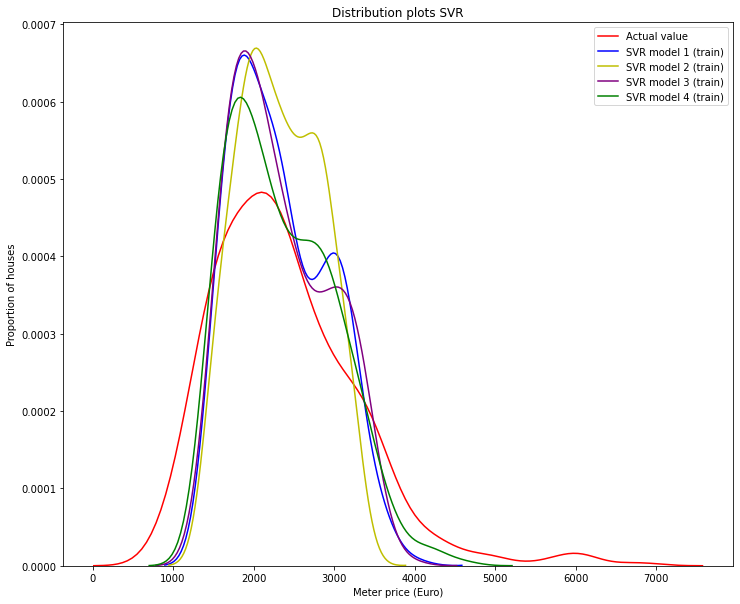

In [90]:
# -- Print scores
print("SVR model, dataset 1 score: {}; RMSE: {}".format(score_svr1, rmse_svr1))
print("SVR model, dataset 2 score: {}; RMSE: {}".format(score_svr2, rmse_svr2))
print("SVR model, dataset 3 score: {}; RMSE: {}".format(score_svr3, rmse_svr3))
print("SVR model, dataset 4 score: {}; RMSE: {}".format(score_svr4, rmse_svr4))
# -- Plot distributions plots
plt.figure(figsize=(width, height))
ax1 = seaborn.distplot(y_train, hist=False, color="r", label="Actual value")
seaborn.distplot(y_train_hat_svr1, hist=False, color="b", label="SVR model 1 (train)", ax=ax1)
seaborn.distplot(y_train_hat_svr2, hist=False, color="y", label="SVR model 2 (train)", ax=ax1)
seaborn.distplot(y_train_hat_svr3, hist=False, color="purple", label="SVR model 3 (train)", ax=ax1)
seaborn.distplot(y_train_hat_svr4, hist=False, color="g", label="SVR model 4 (train)", ax=ax1)
plt.title("Distribution plots SVR")
plt.xlabel('Meter price (Euro)')
plt.ylabel('Proportion of houses')
plt.show()

The SVR models did not perform really well.

Let's try one last model, this time using decision trees.

#### Random forest regressor

For this project, let's perform a little bit of parameters grid searching: let's try to change the number of estimators to 5, 10, 50, 100, 200 estimators.

Again let's use GridSearchCV.

In [91]:
# Create parameters grid for Grid Search CV
parameters_rf = [{'n_estimators': [5, 10, 50, 100, 200]}]
# -- Random Forest dataset 1
gscv_rf1 = GridSearchCV(RandomForestRegressor(random_state=0), parameters_rf, cv=5).fit(X_train1, y_train)
# R2
score_rf1 = gscv_rf1.best_estimator_.score(X_train1, y_train)
# RMSE
y_train_hat_rf1 = gscv_rf1.best_estimator_.predict(X_train1)
rmse_rf1 = np.sqrt(mean_squared_error(y_train, y_train_hat_rf1))
# -- Random Forest dataset 2
gscv_rf2 = GridSearchCV(RandomForestRegressor(random_state=0), parameters_rf, cv=5).fit(X_train2, y_train)
# R2
score_rf2 = gscv_rf2.best_estimator_.score(X_train2, y_train)
# RMSE
y_train_hat_rf2 = gscv_rf2.best_estimator_.predict(X_train2)
rmse_rf2 = np.sqrt(mean_squared_error(y_train, y_train_hat_rf2))
# -- Random Forest dataset 3
gscv_rf3 = GridSearchCV(RandomForestRegressor(random_state=0), parameters_rf, cv=5).fit(X_train3, y_train)
# R2
score_rf3 = gscv_rf3.best_estimator_.score(X_train3, y_train)
# RMSE
y_train_hat_rf3 = gscv_rf3.best_estimator_.predict(X_train3)
rmse_rf3 = np.sqrt(mean_squared_error(y_train, y_train_hat_rf3))
# -- Random Forest dataset 4
gscv_rf4 = GridSearchCV(RandomForestRegressor(random_state=0), parameters_rf, cv=5).fit(X_train4, y_train)
# R2
score_rf4 = gscv_rf4.best_estimator_.score(X_train4, y_train)
# RMSE
y_train_hat_rf4 = gscv_rf4.best_estimator_.predict(X_train4)
rmse_rf4 = np.sqrt(mean_squared_error(y_train, y_train_hat_rf4))
# -- Print scores
print("Random forest model, dataset 1 score: {}; RMSE: {}".format(score_rf1, rmse_rf1))
print("Random forest model, dataset 2 score: {}; RMSE: {}".format(score_rf2, rmse_rf2))
print("Random forest model, dataset 3 score: {}; RMSE: {}".format(score_rf3, rmse_rf3))
print("Random forest model, dataset 4 score: {}; RMSE: {}".format(score_rf4, rmse_rf4))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jupyterlab/conda/envs/python

Random forest model, dataset 1 score: 0.9178409080095267; RMSE: 260.06961377749593
Random forest model, dataset 2 score: 0.9352878489056602; RMSE: 230.81005022414215
Random forest model, dataset 3 score: 0.9307528069732135; RMSE: 238.76072235175386
Random forest model, dataset 4 score: 0.9380498214473579; RMSE: 225.83075085596542


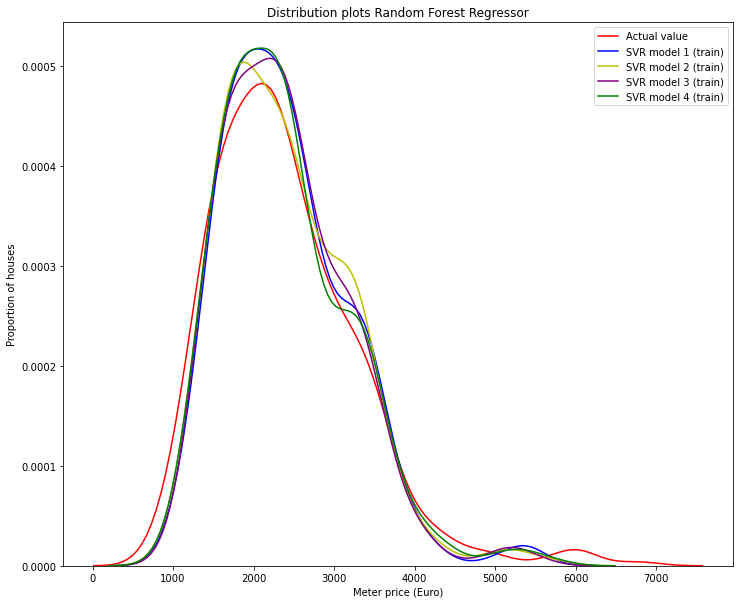

In [92]:
# -- Plot distributions plots
plt.figure(figsize=(width, height))
ax1 = seaborn.distplot(y_train, hist=False, color="r", label="Actual value")
seaborn.distplot(y_train_hat_rf1, hist=False, color="b", label="SVR model 1 (train)", ax=ax1)
seaborn.distplot(y_train_hat_rf2, hist=False, color="y", label="SVR model 2 (train)", ax=ax1)
seaborn.distplot(y_train_hat_rf3, hist=False, color="purple", label="SVR model 3 (train)", ax=ax1)
seaborn.distplot(y_train_hat_rf4, hist=False, color="g", label="SVR model 4 (train)", ax=ax1)
plt.title("Distribution plots Random Forest Regressor")
plt.xlabel('Meter price (Euro)')
plt.ylabel('Proportion of houses')
plt.show()

This time the models obtained a slightly better performance.

The models also almost captured the little spike of prices around 6000, even if centered around 5500. The distributionn is also quite good in the other price ranges, even if also random forests captured the wrong behavior around 3000 euros also seen by Multivariate Linear Regression.

Also in this case, the 4th dataset performed better than the others, even if the difference is lower.

#### Best models comparison

At the end, the result with the training set stated that the 4th feature set is the best performing one.
Adding spatial information with Foursquare allowed to increase the performance of the models.

Let's choose then for the test set evaluation, the models created with the 4th dataset, that obtained the best scores during training.

Let's plot, to summarizez, the distributions of the predicted prices with those models.

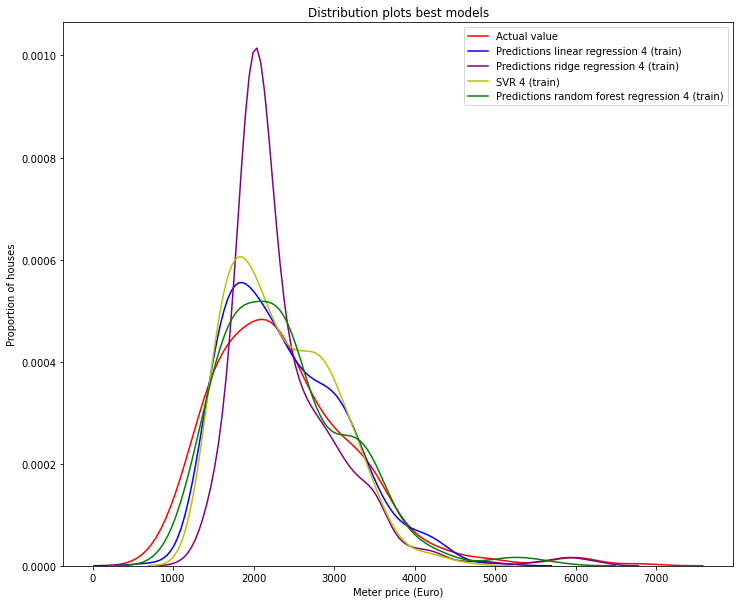

In [93]:
# -- Plot distribution plots of the best models
plt.figure(figsize=(width, height))
ax1 = seaborn.distplot(y_train, hist=False, color="r", label="Actual value")
seaborn.distplot(y_train_hat_lr4, hist=False, color="b", label="Predictions linear regression 4 (train)", ax=ax1)
seaborn.distplot(y_train_hat_rr4, hist=False, color="purple", label="Predictions ridge regression 4 (train)", ax=ax1)
seaborn.distplot(y_train_hat_svr4, hist=False, color="y", label="SVR 4 (train)", ax=ax1)
seaborn.distplot(y_train_hat_rf4, hist=False, color="g", label="Predictions random forest regression 4 (train)", ax=ax1)
plt.title("Distribution plots best models")
plt.xlabel('Meter price (Euro)')
plt.ylabel('Proportion of houses')
plt.show()

Let's investigate what have been the worst predictions obtained with random forest regression.

To do this, let's add a DELTA_PRICE column to the houses dataset, and plot the samples with the highest and lowest delta price.

In [94]:
# Insert predicted price of random forest regressor
enc_houses_df.insert(21, "METER_PRICE_RF", y_train_hat_rf4)
# Insert delta price between target and predicted prices
enc_houses_df.insert(22, "DELTA_PRICE", enc_houses_df["METER_PRICE_RF"] - enc_houses_df["METER_PRICE"])
#Let's see maximum and minimum deltas
enc_houses_df[(enc_houses_df["DELTA_PRICE"] == enc_houses_df["DELTA_PRICE"].max()) | (enc_houses_df["DELTA_PRICE"] == enc_houses_df["DELTA_PRICE"].min())].head()

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,GROUND,MIDDLE,LAST,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE,LAT,LNG,METER_PRICE_RF,DELTA_PRICE,CLUSTER,CLUSTER_VENUES
14,1160000,2 piazza Garibaldi,4,171,2,2.0,1,0,0,1,2016,3.0,1.0,0.0,0.0,3.0,1,2.0,6783.625731,45.58433,9.27747,5728.012742,-1055.612989,8,2
141,390000,8 via Asiago,5,180,3,2.0,2,0,1,1,2021,3.0,1.0,0.0,0.0,6.0,4,0.0,2166.666667,45.56093,9.25753,2929.870028,763.203361,7,3


They both are particular cases. 

The first house, in fact, has a price of 1160000 euros but with only 4 rooms and 171 square meters, that results in a square meter price of 5758 euros. This house is quite expensive, as confirmed also by the GRADE feature.

Vice versa, the second house is quite cheap, having a price of 390000 euros but with 5 rooms and 180 square meters, resulting in a square meter price of 2929.87 euros.

To have a visual inspection of the delta prices, let's plot again the training set with folium this time assigning to each CircleMarker a colormap from green to red depending on the delta price value.

In [95]:
# Create Monza map with folium using Monza's nominal coordinates
MONZA_COORDINATES = [45.5804, 9.2759]
monza_map = folium.Map(location=MONZA_COORDINATES, zoom_start=14)
# Define colormap for delta price from min delta to max absolute delta
max_delta = enc_houses_df["DELTA_PRICE"].abs().max()
deltas_colormap = cm.LinearColormap(colors=['green','red'], index=[0, max_delta], vmin=0, vmax=max_delta)
# Add all the houses to the map, set radius dimension depending on radius
for lat, lng, price, address, met_price, met_price_rf, delta_price in zip(enc_houses_df['LAT'], 
                                                                          enc_houses_df['LNG'], 
                                                                          enc_houses_df['PRICE'], 
                                                                          enc_houses_df['ADDRESS'], 
                                                                          enc_houses_df['METER_PRICE'], 
                                                                          enc_houses_df['METER_PRICE_RF'],
                                                                          enc_houses_df["DELTA_PRICE"]):
    # Set label as "address; price; meter price, meter price random forests, delta price"
    label = folium.Popup("Address: {}; Price: {}; Met price: {}; Met price rf: {}; Delta price: {}".format(address, 
                                                                                                           price, 
                                                                                                           met_price, 
                                                                                                           met_price_rf, 
                                                                                                           delta_price), parse_html=True)
    # Set circle radius to be proportional to meter price, with maximum radius of 5 and with different color for neighborhoods
    folium.CircleMarker(
        [lat, lng],
        radius=10 * (met_price / np.max(enc_houses_df['METER_PRICE'])),
        weight=1,
        popup=label,
        color=deltas_colormap(abs(delta_price)),
        fill=True,
        fill_color=deltas_colormap(abs(delta_price)),
        fill_opacity=1,
        parse_html=False).add_to(monza_map)  
monza_map

It can be seen that the houses with the highest errors are also the houses with the higher square meter price, confirming that the model is not very accurate when the square meter price is above the average.## MODELS EVALUATION ON TEST SET

## Regression: testing the best models <a name="testing"></a>

Now that we have found the best performing models on training set, let's test the generalization performance of the four best models with the test set.

#### Load test dataset

To test the generalization performance, let's evaluate the models predictions using a test set of houses never seen during training phase.
The test houses dataset has the same format of the initial training dataset, so let's perform all the encoding pipeline and Foursquare venues features retrieval.

As first step, load the csv file with pandas.

In [96]:
# Read initial csv file
test_houses_df = pd.read_csv("TEST_HOUSES.csv", delimiter=";")
test_houses_df.head(10)

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE
0,350000,88 via Lecco,5,155,2,MIDDLE,1,1970,GOOD,NO,NO,YES,G,1,CHEAP
1,148000,42 via Gaetano Donizzetti,3,75,1,GROUND,1,1950,BAD,NO,NO,NO,G,1,CHEAP
2,847000,2 piazza Giuseppe Garibaldi,4,155,2,MIDDLE,1,2015,NEW,NO,NO,NO,B,1,EXPENSIVE
3,85000,via Pellegrino Pellegrini,3,95,1,LAST,1,1967,BAD,NO,YES,NO,G,2,CHEAP
4,261300,viale Ugo Foscolo,2,78,2,MIDDLE,1,2021,NEW,YES,YES,NO,A1,2,EXPENSIVE
5,179000,55 via Adda,3,107,2,LAST,2,2012,GOOD,YES,YES,NO,B,2,NORMAL
6,138000,via Pellegrino Pellegrini,4,110,1,MIDDLE,1,1960,GOOD,NO,YES,NO,E,2,CHEAP
7,150000,via Pellegrino Pellegrini,3,90,2,GROUND,1,1970,RENOVATED,NO,YES,NO,G,2,NORMAL
8,261900,via Claudio Monteverdi,2,71,1,MIDDLE,1,2021,NEW,YES,NO,NO,A3,3,EXPENSIVE
9,329000,7 via Gian Lorenzo Bernini,3,106,2,LAST,1,2011,GOOD,NO,YES,NO,B,3,EXPENSIVE


#### Test set preprocessing

The first preprocessing step is encoding: let's use the Ordinal Encoder created during training phase, then perform the custom encoding of FLOOR and FLOORS features, and as last step create the meter price column.

In [25]:
# Perform ordinal encoding of categorical features
columns_to_encode = ['FLOOR', 'STATUS', 'ENERGY', 'GRADE', 'TERRACE', 'GARDEN', 'GARAGE']
enc_test_houses_df = test_houses_df.copy()
enc_test_houses_df[columns_to_encode] = ord_enc.transform(enc_test_houses_df[columns_to_encode])
# Perform custom one hot encoding for FLOOR and FLOORS features
enc_test_houses_df = encodeFloors(enc_test_houses_df)
# Crete meter price column
enc_test_houses_df['METER_PRICE'] = enc_test_houses_df['PRICE'] / enc_test_houses_df['METERS']
enc_test_houses_df.head()

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,GROUND,MIDDLE,LAST,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE
0,350000,88 via Lecco,5,155,2,1.0,1,0,1,0,1970,1.0,0.0,0.0,1.0,0.0,1,0.0,2258.064516
1,148000,42 via Gaetano Donizzetti,3,75,1,0.0,1,1,0,0,1950,0.0,0.0,0.0,0.0,0.0,1,0.0,1973.333333
2,847000,2 piazza Giuseppe Garibaldi,4,155,2,1.0,1,0,1,0,2015,3.0,0.0,0.0,0.0,5.0,1,2.0,5464.516129
3,85000,via Pellegrino Pellegrini,3,95,1,2.0,1,0,0,1,1967,0.0,0.0,1.0,0.0,0.0,2,0.0,894.736842
4,261300,viale Ugo Foscolo,2,78,2,1.0,1,0,1,0,2021,3.0,1.0,1.0,0.0,7.0,2,2.0,3350.000000


As second step, let's create latitude and longidute coordinates with geopy and plot the houses with folium.

In [97]:
# Call geocode function to retrieve latitudes and longitues. This will take a while...
enc_test_houses_df = geocode_dataframe(enc_test_houses_df)
enc_test_houses_df.head()

,PRICE,ADDRESS,ROOMS,METERS,BATHROOMS,FLOOR,FLOORS,GROUND,MIDDLE,LAST,YEAR,STATUS,TERRACE,GARDEN,GARAGE,ENERGY,NEIGHBORHOOD,GRADE,METER_PRICE,LAT,LNG
0,350000,88 via Lecco,5,155,2,1.0,1,0,1,0,1970,1.0,0.0,0.0,1.0,0.0,1,0.0,2258.064516,45.591070,9.289070
1,148000,42 via Gaetano Donizzetti,3,75,1,0.0,1,1,0,0,1950,0.0,0.0,0.0,0.0,0.0,1,0.0,1973.333333,45.596010,9.263770
2,847000,2 piazza Giuseppe Garibaldi,4,155,2,1.0,1,0,1,0,2015,3.0,0.0,0.0,0.0,5.0,1,2.0,5464.516129,45.584330,9.277470
3,85000,via Pellegrino Pellegrini,3,95,1,2.0,1,0,0,1,1967,0.0,0.0,1.0,0.0,0.0,2,0.0,894.736842,45.580377,9.305210
4,261300,viale Ugo Foscolo,2,78,2,1.0,1,0,1,0,2021,3.0,1.0,1.0,0.0,7.0,2,2.0,3350.000000,45.576397,9.289948


In [98]:
# Create Monza map with folium using Monza's nominal coordinates
MONZA_COORDINATES = [45.5804, 9.2759]
monza_map = folium.Map(location=MONZA_COORDINATES, zoom_start=14)
# Define colors for each neighborhood
house_colors = {1:'#ff0000', 2:'#707070', 3:'#00b000', 4:'#993333', 5:'#aa7878', 6:'#000000', 7:'#0000aa', 8:'#505050', 9:'#b056a5'}
# Add all the houses to the map, set radius dimension depending on radius
for lat, lng, price, address, met_price, neighborhood in zip(enc_test_houses_df['LAT'], 
                                                             enc_test_houses_df['LNG'], 
                                                             enc_test_houses_df['PRICE'], 
                                                             enc_test_houses_df['ADDRESS'], 
                                                             enc_test_houses_df['METER_PRICE'], 
                                                             enc_test_houses_df['NEIGHBORHOOD']):
    # Set label as "address; price"
    label = folium.Popup("{}; {}".format(address, price), parse_html=True)
    # Set circle radius to be proportional to meter price, with maximum radius of 5 and with different color for neighborhoods
    folium.CircleMarker(
        [lat, lng],
        radius=10 * (met_price / np.max(enc_test_houses_df['METER_PRICE'])),
        weight=1,
        popup=label,
        color=house_colors[neighborhood],
        fill=True,
        fill_color=house_colors[neighborhood],
        fill_opacity=1,
        parse_html=False).add_to(monza_map)  
monza_map

The test set contains a few houses each house representative of the neighborhood.

As last step let's create the venues features using Foursquare.

In [99]:
# Create test houses venues dataframe
test_houses_venues_df=enc_test_houses_df[['LAT', 'LNG']].append(pd.DataFrame(columns = monza_30top_venues))
test_houses_venues_df.fillna(value=0, inplace=True)
# Now, call the function to fill the venue presence for each house
test_houses_venues_df = getHousesVenues(test_houses_venues_df)
test_houses_venues_df.head()

,LAT,LNG,Villa Reale,Piazza Trento e Trieste,Istituti Clinici Zucchi,Parco di Monza - Ingresso Alle Grazie,U2,Parco di Monza - Viale cavriga,Dori,Civico 1,La Rinascente,Duomo di Monza,Macellerie Monzesi,La Feltrinelli,Alcott,Piazza Carrobiolo,Roseto della Villa Reale,Pasticceria Viganò,Moderno Pasticceria Confetteria,Monzello,Le dolcezze di Mister C,Rondò dei Pini,Tearose Cafè,Serrone della Villa Reale,Teatro Manzoni,Coco Le Patissier,Osteria Bacco e Tabacco,Derby Grill,Exfactory,Nespresso Boutique
0,45.591070,9.289070,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,45.596010,9.263770,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
2,45.584330,9.277470,0,1,1,0,0,0,1,0,1,1,0,1,1,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1
3,45.580377,9.305210,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,45.576397,9.289948,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Since that now we are testing only the best models, that are the ones that use the venues features directly, we skip the clustering phase.

#### Test set evaluation

At first, let's prepare the features test set standardized with the previously defined Standard Scaler and the target prices vector.

In [100]:
# Prepare test feature set using standard scaler #4
test_features = pd.concat(objs=[enc_test_houses_df[features], test_houses_venues_df.iloc[:, 2:]], axis=1)
X_test = st_scaler4.transform(test_features)
# Prepare test feature set with polynomial transformation
X_test_pf = pf4.transform(X_test)
# Get target prices
y_test = enc_test_houses_df["METER_PRICE"]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


And as last step, let's compute the performances of the models and plot the distributions plots.

In [101]:
# --- Multivariate linear regression
# R2
score_lr4 = lr4.score(X_test, y_test)
# RMSE
y_test_hat_lr4 = lr4.predict(X_test)
rmse_lr4 = np.sqrt(mean_squared_error(y_test, y_test_hat_lr4))
# --- Ridge regression
# R2
score_rr4 = gscv_rr4.best_estimator_.score(X_test_pf, y_test)
# RMSE
y_test_hat_rr4 = gscv_rr4.best_estimator_.predict(X_test_pf)
rmse_rr4 = np.sqrt(mean_squared_error(y_test, y_test_hat_rr4))
# --- SVR
# R2
score_svr4 = gscv_svr4.best_estimator_.score(X_test, y_test)
# RMSE
y_test_hat_svr4 = gscv_svr4.best_estimator_.predict(X_test)
rmse_svr4 = np.sqrt(mean_squared_error(y_test, y_test_hat_svr4))
# --- Random forest
# R2
score_rf4 = gscv_rf4.best_estimator_.score(X_test, y_test)
# RMSE
y_test_hat_rf4 = gscv_rf4.best_estimator_.predict(X_test)
rmse_rf4 = np.sqrt(mean_squared_error(y_test, y_test_hat_rf4))
# --- Print scores
print("Linear Regression Model, score: {}; RMSE: {}".format(score_lr4, rmse_lr4))
print("Ridge regression Model, score: {}; RMSE: {}".format(score_rr4, rmse_rr4))
print("SVR Model, score: {}; RMSE: {}".format(score_svr4, rmse_svr4))
print("Random Forest Model, score: {}; RMSE: {}".format(score_rf4, rmse_rf4))

Linear Regression Model, score: 0.31291246434030573; RMSE: 752.6093608607518
Ridge regression Model, score: 0.46391327523659326; RMSE: 664.784839969178
SVR Model, score: 0.4427798878718109; RMSE: 677.7616202386137
Random Forest Model, score: 0.6975391499360923; RMSE: 499.3420786976193


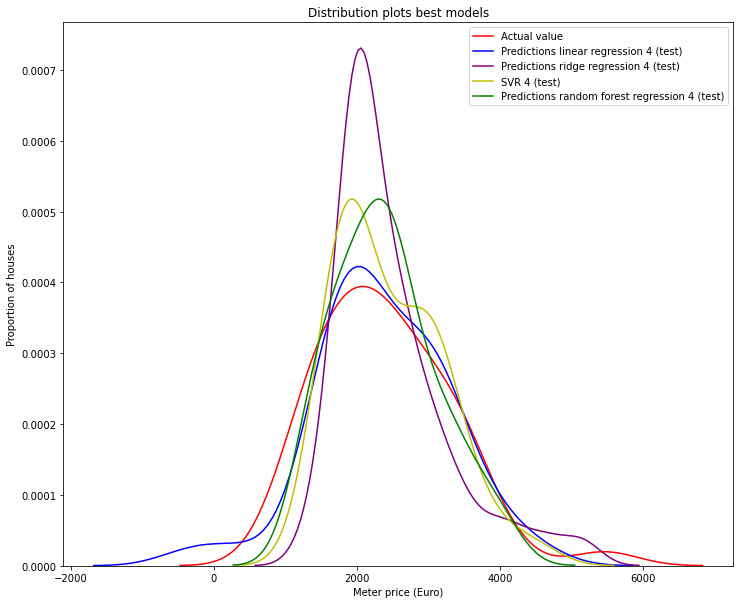

In [102]:
# -- Plot distribution plots of the best models
plt.figure(figsize=(width, height))
ax1 = seaborn.distplot(y_test, hist=False, color="r", label="Actual value")
seaborn.distplot(y_test_hat_lr4, hist=False, color="b", label="Predictions linear regression 4 (test)", ax=ax1)
seaborn.distplot(y_test_hat_rr4, hist=False, color="purple", label="Predictions ridge regression 4 (test)", ax=ax1)
seaborn.distplot(y_test_hat_svr4, hist=False, color="y", label="SVR 4 (test)", ax=ax1)
seaborn.distplot(y_test_hat_rf4, hist=False, color="g", label="Predictions random forest regression 4 (test)", ax=ax1)
plt.title("Distribution plots best models")
plt.xlabel('Meter price (Euro)')
plt.ylabel('Proportion of houses')
plt.show()

## Conclusion <a name="conclusion"></a>

In this project I evaluated the performance of 4 regression models with 4 different feature sets on the Monza house price prediction problem.

The results suggested that the usage of Foursquare retrieving a feature set indicating the presence of the top trend venues in the vicinity of the house can improve the models performance with respect of using only the house characteristics features. Finally, that Random Forest Regression model outperformed the other models scores.

However, there are many improvements that can be done, that can be summarized in the following points:

- The training set can be enlarged, by including more samples with high square meter price in order to let the model better capture the relations in that price range.
- The spatial information can also be improved, in particular it should be find a way to stabilize the top trend venues features
- Other features of the house characteristics could also be added, the STATUS feature can be better stated
- Other models can be tested and also the existing ones can be fine-tuned
- It could also be possible to try a classification problem by predicting the GRADE feature using the house price as one of the features and not as target variable.